In [274]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import scipy.stats
from datetime import datetime
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from Bio import Entrez

In [62]:
df = pd.read_csv('CNC_San_Francisco_2017.csv')

In [18]:
df.head()

,captive,created_at,created_time_zone,description,faves_count,geoprivacy,iconic_taxon_name,id,identifications,identifications_most_agree,...,taxon_native,taxon_observations,taxon_parent_id,taxon_rank,taxon_search_rank,taxon_threatened,time_observed_at,updated_at,user_id,user_login
0,False,2017-04-13T13:29:41-07:00,America/Los_Angeles,NaN,0,NaN,Insecta,5677489,"[{'user_id': 8778, 'category': 'maverick', 'di...",True,...,False,118929.0,49025.0,family,118929.0,False,2017-04-13T12:40:50-07:00,2018-11-26T12:33:26-08:00,8778,gyrrlfalcon
1,False,2017-04-13T18:37:08-07:00,America/Los_Angeles,NaN,0,NaN,Plantae,5682279,"[{'user_id': 179103, 'category': 'supporting',...",True,...,True,8614.0,48245.0,species,8614.0,False,2017-04-13T15:57:53-07:00,2018-11-26T06:03:56-08:00,4797,paranger
2,False,2017-04-13T18:44:41-07:00,America/Los_Angeles,NaN,0,NaN,Plantae,5682371,"[{'user_id': 179103, 'category': 'supporting',...",True,...,True,8614.0,48245.0,species,8614.0,False,2017-04-13T16:08:07-07:00,2018-11-26T06:03:57-08:00,4797,paranger
3,False,2017-04-14T00:20:21-07:00,America/Los_Angeles,NaN,0,obscured,Insecta,5684642,"[{'user_id': 1, 'category': None, 'disagreemen...",False,...,False,6463.0,55518.0,family,6463.0,False,2017-04-14T00:13:00-07:00,2017-04-21T14:58:31-07:00,1,kueda
4,False,2017-04-14T00:29:36-07:00,America/Los_Angeles,NaN,0,NaN,Insecta,5684660,"[{'user_id': 3494, 'category': 'leading', 'dis...",True,...,False,1176.0,67740.0,subgenus,1176.0,False,2017-04-14T00:28:12-07:00,2020-02-15T14:31:49-08:00,3494,damontighe


In [8]:
df.shape

(24051, 38)

In [16]:
df = df.dropna(subset=['iconic_taxon_name'])

In [19]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [26]:
users_counts = df.groupby(['user_id'])['id'].count().reset_index()
users_counts.columns = ['user_id', 'count']

In [61]:
np.percentile(users_counts['count'], 75)

17.0

In [63]:
selected = users_counts.query('count >= 17')['user_id']

In [64]:
df_f = df[df['user_id'].isin(selected)]

In [284]:
Entrez.email = "vadimvoskresenskiy@gmail.com"
handle = Entrez.efetch(db="Taxonomy", id="53237", retmode="xml")

In [285]:
records = Entrez.read(handle)

In [281]:
df_f.columns

Index(['captive', 'created_at', 'created_time_zone', 'description',
       'faves_count', 'geoprivacy', 'iconic_taxon_name', 'id',
       'identifications', 'identifications_most_agree',
       'identifications_most_disagree', 'latitude', 'longitude',
       'num_identification_agreements', 'num_identification_disagreements',
       'obscured', 'observed_on_string', 'place_guess', 'place_ids',
       'positional_accuracy', 'preferred_common_name', 'quality_grade',
       'reviewed_by', 'species_guess', 'taxon_endemic', 'taxon_geoprivacy',
       'taxon_id', 'taxon_name', 'taxon_native', 'taxon_observations',
       'taxon_parent_id', 'taxon_rank', 'taxon_search_rank',
       'taxon_threatened', 'time_observed_at', 'updated_at', 'user_id',
       'user_login'],
      dtype='object')

In [295]:
df_f['taxon_parent_id'][0:5]

0    49025.0
3    55518.0
4    67740.0
6    53113.0
7    52991.0
Name: taxon_parent_id, dtype: float64

In [289]:
handle = Entrez.esearch(db="Taxonomy", term="Cicadellidae")

In [290]:
record = Entrez.read(handle)

In [291]:
record

{'Count': '1', 'RetMax': '1', 'RetStart': '0', 'IdList': ['30102'], 'TranslationSet': [], 'TranslationStack': [{'Term': 'Cicadellidae[All Names]', 'Field': 'All Names', 'Count': '1', 'Explode': 'N'}, 'GROUP'], 'QueryTranslation': 'Cicadellidae[All Names]'}

In [296]:
handle = Entrez.efetch(db="Taxonomy", id="30102", retmode="xml")
records = Entrez.read(handle)

In [297]:
records

[{'TaxId': '30102', 'ScientificName': 'Cicadellidae', 'OtherNames': {'CommonName': [], 'Acronym': [], 'Teleomorph': [], 'Misspelling': [], 'GenbankSynonym': [], 'Name': [], 'EquivalentName': [], 'Includes': [], 'Anamorph': [], 'GenbankAnamorph': [], 'Inpart': [], 'Misnomer': [], 'Synonym': ['Jassidae'], 'GenbankCommonName': 'leafhoppers'}, 'ParentTaxId': '33368', 'Rank': 'family', 'Division': 'Invertebrates', 'GeneticCode': {'GCId': '1', 'GCName': 'Standard'}, 'MitoGeneticCode': {'MGCId': '5', 'MGCName': 'Invertebrate Mitochondrial'}, 'Lineage': 'cellular organisms; Eukaryota; Opisthokonta; Metazoa; Eumetazoa; Bilateria; Protostomia; Ecdysozoa; Panarthropoda; Arthropoda; Mandibulata; Pancrustacea; Hexapoda; Insecta; Dicondylia; Pterygota; Neoptera; Paraneoptera; Hemiptera; Auchenorrhyncha; Cicadomorpha; Membracoidea', 'LineageEx': [{'TaxId': '131567', 'ScientificName': 'cellular organisms', 'Rank': 'no rank'}, {'TaxId': '2759', 'ScientificName': 'Eukaryota', 'Rank': 'superkingdom'}, {'

In [288]:
df_f['taxon_name'][0:5]

0             Cicadellidae
3            Blastobasidae
4               Sophophora
6           Brassica nigra
7    Carduus pycnocephalus
Name: taxon_name, dtype: object

In [17]:
set(df['iconic_taxon_name'])

{'Actinopterygii',
 'Amphibia',
 'Animalia',
 'Arachnida',
 'Aves',
 'Chromista',
 'Fungi',
 'Insecta',
 'Mammalia',
 'Mollusca',
 'Plantae',
 'Protozoa',
 'Reptilia'}

In [17]:
set(df['iconic_taxon_name'])

{'Actinopterygii',
 'Amphibia',
 'Animalia',
 'Arachnida',
 'Aves',
 'Chromista',
 'Fungi',
 'Insecta',
 'Mammalia',
 'Mollusca',
 'Plantae',
 'Protozoa',
 'Reptilia'}

In [147]:
df_taxons = df_f.groupby(['user_id', 'taxon_name']).agg('id').count().reset_index()
df_taxons = df_taxons.pivot(index='user_id',columns='taxon_name',values='id')
df_taxons = df_taxons.fillna(0)

In [149]:
scaler = StandardScaler()
taxons_scaled = scaler.fit_transform(df_taxons)

In [150]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(taxons_scaled)

([<matplotlib.axis.XTick at 0x20a9b4c6e48>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

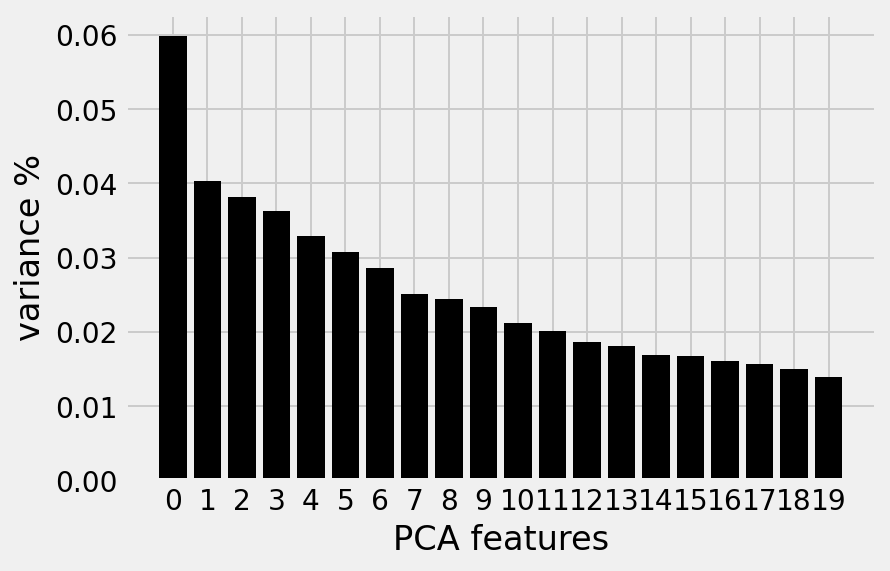

In [152]:
%config InlineBackend.figure_format='retina'
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [154]:
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

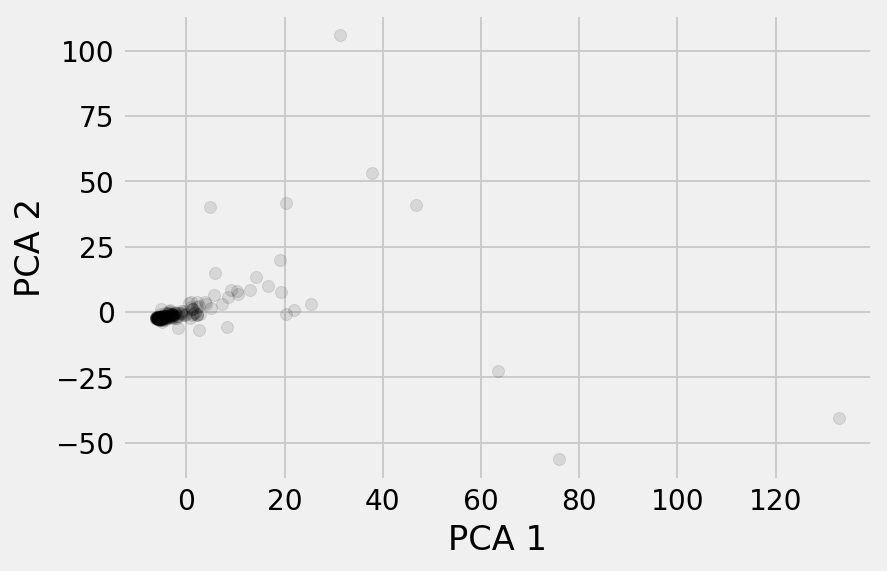

In [155]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [73]:
temp = df_f.groupby(['user_id', 'iconic_taxon_name']).agg('id').count().reset_index()
wide_cross = temp.pivot(index='user_id',columns='iconic_taxon_name',values='id')
wide_cross = wide_cross.fillna(0)

In [79]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(wide_cross)

In [80]:
scaled_features

array([[-0.2447451 ,  0.19843374, -0.18239509, ...,  1.47060489,
        -0.27657633, -0.50725316],
       [ 1.75400659,  0.19843374,  1.24758241, ...,  0.78050352,
        -0.27657633,  0.36486631],
       [-0.2447451 , -0.39992031, -0.32539284, ...,  0.03444797,
        -0.27657633, -0.50725316],
       ...,
       [-0.2447451 , -0.39992031, -0.18239509, ..., -0.54374507,
        -0.27657633, -0.50725316],
       [-0.2447451 , -0.39992031, -0.32539284, ..., -0.48779091,
        -0.27657633, -0.50725316],
       [-0.2447451 , -0.39992031, -0.32539284, ..., -0.20802008,
        -0.27657633, -0.50725316]])

In [81]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

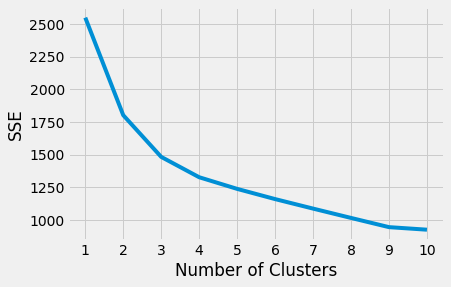

In [82]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [83]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [84]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [85]:
kmeans.fit(scaled_features)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [133]:
users_clusters = pd.DataFrame({'user_id': np.array(wide_cross.index), 'cluster': kmeans.labels_}, columns=['user_id', 'cluster'])

In [129]:
users_act = df_f.groupby(['user_id', 'iconic_taxon_name']).agg('id').count().reset_index()

In [134]:
users_clusters = users_clusters.merge(users_act, on = 'user_id', how = 'left')

In [188]:
specs = []
for i in set(df_f['user_id']):
    df_filt = df_f[df_f['user_id'] == i]
    spec = df_filt['taxon_name'].tolist()
    spec_cl = [x for x in spec if str(x) != 'nan']
    specs.append(spec_cl)

In [205]:
lens =[len(s) for s in specs]
np.mean(lens)

110.25510204081633

In [192]:
model = Word2Vec(specs, min_count=1)

In [195]:
X = model[model.wv.vocab]

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [200]:
print(model.similarity(specs[1][1], specs[5][7]))

0.9918928


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [232]:
df_f['taxon_name'][0:10]

0                 Cicadellidae
3                Blastobasidae
4                   Sophophora
6               Brassica nigra
7        Carduus pycnocephalus
8             Conium maculatum
9     Scrophularia californica
10       Corvus brachyrhynchos
11              Cornu aspersum
12              Cornu aspersum
Name: taxon_name, dtype: object

In [233]:
model.most_similar(["Corvus brachyrhynchos"])

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Calypte anna', 0.99888014793396),
 ('Haemorhous mexicanus', 0.9988642930984497),
 ('Junco hyemalis', 0.9986411333084106),
 ('Zenaida macroura', 0.9982700943946838),
 ('Melozone crissalis', 0.9981430172920227),
 ('Aphelocoma californica', 0.9981343150138855),
 ('Sayornis nigricans', 0.9981138706207275),
 ('Anas platyrhynchos', 0.998091459274292),
 ('Egretta thula', 0.9979921579360962),
 ('Phalacrocorax auritus', 0.9979863166809082)]

In [220]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

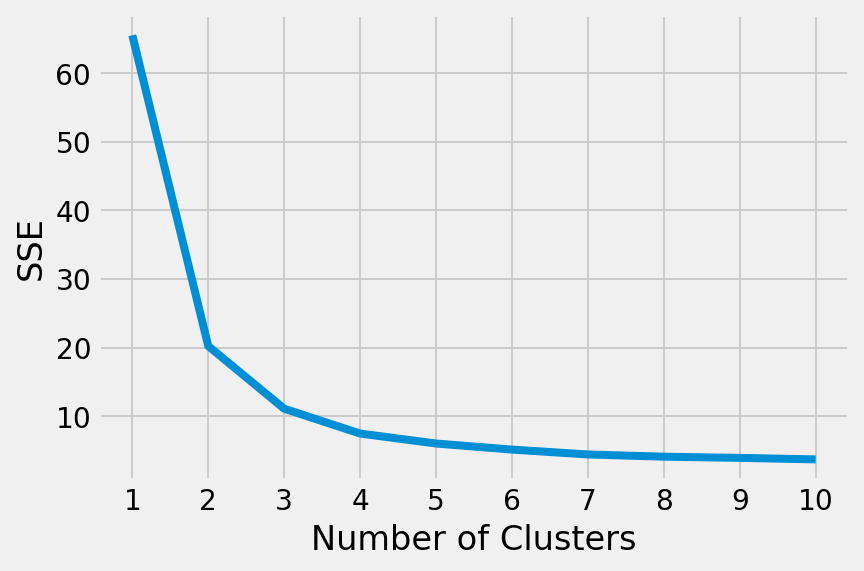

In [221]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [222]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [223]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [224]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [225]:
kmeans.labels_

array([0, 1, 0, ..., 0, 0, 0])

In [234]:
w2v_vectors = model.wv.vectors

In [236]:
w2v_indices = {word: model.wv.vocab[word].index for word in model.wv.vocab}

In [239]:
def vectorize(line): 
    words = []
    for word in line: # line - iterable, for example list of tokens 
        try:
            w2v_idx = w2v_indices[word]
        except KeyError: # if you does not have a vector for this word in your w2v model, continue 
            continue
        words.append(w2v_vectors[w2v_idx])
        if words: 
            words = np.asarray(words)
            min_vec = words.min(axis=0)
            max_vec = words.max(axis=0)
            return np.concatenate((min_vec, max_vec))
        if not words:
            return None 

In [273]:
vectorize(specs[0][0:3])

array([ 3.6695271e-03, -2.7862608e-03,  3.6105997e-04, -7.4896780e-03,
       -5.3076237e-03, -1.8150086e-03, -1.5051538e-03, -9.7644208e-03,
        2.0787821e-03,  4.4959484e-04, -5.3621838e-03, -5.0769141e-03,
        2.6090250e-03,  3.7617625e-03,  4.8260004e-03, -3.7780334e-03,
        2.2845999e-03, -2.6746615e-04,  6.3860156e-03, -1.4045956e-02,
       -6.8647356e-04, -6.5421448e-03,  6.1484044e-03,  8.5573085e-03,
       -2.2248439e-03,  1.5472625e-03,  7.1541579e-03,  3.3680582e-03,
        6.7321979e-03, -6.6867131e-03, -1.6695793e-03, -4.3073725e-03,
        1.8323712e-03, -1.3500860e-05, -1.0232343e-03,  4.0272818e-04,
       -1.6181794e-03, -4.3155481e-03,  1.9986618e-03,  7.8090705e-04,
       -1.2636175e-03,  1.4332603e-03,  3.7349230e-03,  5.2894200e-03,
        2.2502816e-03,  2.4437509e-03,  1.8390833e-04,  4.4450182e-03,
       -4.2424368e-04, -3.0328177e-03, -1.4811006e-03, -4.5892871e-03,
       -6.1478675e-04, -1.0179095e-02, -8.4789604e-04, -1.1962984e-02,
      

In [272]:
specs[0][0:3]

['Blastobasidae', 'Erodium botrys', 'Euphydryas']

In [251]:
w2v_idx = w2v_indices[specs[0][0]]

In [261]:
words = w2v_vectors[w2v_idx]
words = np.asarray(words)

In [264]:
words.max(axis=0)

0.010429773